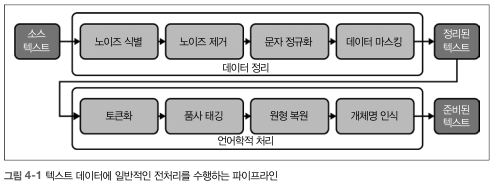

In [1]:
import pandas as pd

In [2]:
file = "./data/rspct_autos.tsv.gz"
posts_df = pd.read_csv(file, sep='\t')

subred_file = "./data/subreddit_info.csv.gz"
subred_df = pd.read_csv(subred_file).set_index(['subreddit'])

In [3]:
posts_df.head()

,id,subreddit,title,selftext
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ..."
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu..."


In [4]:
subred_df.head()

,category_1,category_2,category_3,in_data,reason_for_exclusion
subreddit,,,,,
whatsthatbook,advice/question,book,NaN,True,NaN
CasualConversation,advice/question,broad,NaN,False,too_broad
Clairvoyantreadings,advice/question,broad,NaN,False,too_broad
DecidingToBeBetter,advice/question,broad,NaN,False,too_broad
HelpMeFind,advice/question,broad,NaN,False,too_broad


In [5]:
df = posts_df.join(subred_df, on='subreddit')
df.head()

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,NaN,True,NaN
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford,NaN,True,NaN
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW,NaN,True,NaN
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus,NaN,True,NaN
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet,NaN,True,NaN


In [6]:
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',
    'category_3': None,
    'in_data': None,
    'reason_for_exclusion': None
}

In [7]:
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

In [8]:
df = df[columns].rename(columns=column_mapping)
df.head(2)

,id,subreddit,title,text,category,subcategory
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford


In [9]:
df = df[df['category'] == 'autos']
df.sample(1).T

,9967
id,4qc07u
subreddit,Lexus
title,Need Help/Opinions On Lexus IS
text,Hello /r/Lexus<lb><lb>I am coming to the end o...
category,autos
subcategory,lexus


In [10]:
# save data

# df.to_pickle("./data/reddit_dataframe.pkl")

In [11]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtube.com/watch?v=iehdsg) it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
"""

노이즈 식별

In [12]:
import re

RE_SUSPICIOUS = re.compile(r'[&$<>{}\[\]\\]')

def impurity(text, min_len=10):
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

print(impurity(text))

0.08823529411764706


In [13]:
df['impurity'] = df['text'].apply(impurity, min_len=10)

df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11...,0.214716
12357,I'm looking to lease an a4 premium plus automa...,0.185998
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L...,0.147826


In [14]:
from blueprints.exploration import count_words

In [15]:
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

,freq
token,
<lb>,100729
<tab>,642


노이즈 제거

In [16]:
import html

In [17]:
def clean(text):
    text = html.unescape(text) # &amp;와 같은 thml 이스케이프를 문자로 변환
    text = re.sub(r'<[^<>]*>', ' ', text) # <tab>과 같은 태그를 공백으로 변환
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text) # [Some text](https://....)와 같은 마크다운 URL을 공백으로 변환
    text = re.sub(r'\[[^\[\]]*\]', ' ', text) # [0]과 같은 괄호 안의 텍스트 또는 코드를 공백으로 변환
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{-1,}(?:\s|$)', ' ', text) # 특수 문자로만 구성된 문자열을 공백으로 변환, 이때 &#은 변환되지만 #cool은 변환되지 않음
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text) # --- 또는 == 같은 하이픈으로 이뤄진 문자열을 공백으로 변환
    text = re.sub(r'\s+', ' ', text) # 연속된 공백으로 공백 하나로 변환
    return text.strip()

In [18]:
clean_text = clean(text)

In [19]:
print(clean_text)
print("Impurity:", impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool
Impurity: 0.0


In [20]:
df['clean_text'] = df['text'].map(clean)
df['impurity'] = df['clean_text'].apply(impurity, min_len=20)
df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,clean_text,impurity
7041,Split b/w 2 genesis options. Hyundai Genesis\ ...,0.046512
8700,"E-price: $20,863.00 Freight: $900.00 Processin...",0.041009
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. H...",0.039360


textacy를 사용한 문자 정규화

In [21]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [22]:
import textacy.preprocessing as tprep

In [23]:
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [24]:
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


textacy를 사용한 패턴 기반 데이터 마스킹

In [25]:
from textacy.preprocessing.resources import RE_URL

count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2


In [26]:
from textacy.preprocessing import replace

text = "check out https://spacy.io/usage/spacy-101"

print(replace.urls(text))

check out _URL_


In [27]:
df['clean_text'] = df['clean_text'].map(replace.urls)
df['clean_text'] = df['clean_text'].map(normalize)

In [28]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)

df.head(3)

,id,subreddit,title,raw_text,category,subcategory,text
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,Funny story. I went to college in Las Vegas. T...
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford,"I am trying to determine which is faster, and ..."
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW,Hello! Trying to find some information on repl...


#### 토큰화

In [29]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed 
solution for today's problem. The code of module AC68 should be -1. 
Have to think a bit... #goodnight ;-) 😩😬"""

In [30]:
tokens = re.findall(r'\w\w+', text)

In [31]:
print(*tokens, sep='|')

2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight


In [32]:
RE_TOKEN = re.compile(r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """, re.VERBOSE)

In [33]:
def tokenize(text):
    return RE_TOKEN.findall(text)

In [34]:
tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


NLTK를 사용한 토큰화

In [35]:
import nltk

In [36]:
tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


#### 스페이시를 사용한 언어 처리

In [37]:
import spacy

In [38]:
nlp = spacy.load('en_core_web_sm')

In [39]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1fb492ea4c0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1fb496c9580>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1fb49436820>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1fb49756640>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1fb4974db40>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1fb49436900>)]

In [40]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [41]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1fb492ea0a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1fb4b1ad9a0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1fb4b3836c0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1fb4b380c80>)]

In [42]:
doc = nlp(text)

In [43]:
for token in doc:
    print(token, end="|")


|2019|-|08|-|10|23:32|:|@pete/@louis|-|I|do|n't|have|a|well|-|designed|
|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|
|Have|to|think|a|bit|...|#|goodnight|;-)|😩|😬|

In [51]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_, 
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_, 
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [52]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,\n,\n,False,False,SPACE,,,
1,2019,2019,False,False,NUM,,,
3,08,08,False,False,NUM,,,
5,10,10,False,False,NUM,,,
6,23:32,23:32,False,False,NUM,,,
8,@pete/@louis,@pete/@louis,False,False,NUM,,,
10,I,I,True,True,PRON,,,
11,do,do,True,True,AUX,,,
12,n't,not,True,False,PART,,,
13,have,have,True,True,AUX,,,


In [53]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
nlp = spacy.load('en_core_web_sm') ###
doc = nlp(text)

for token in doc:
    print(token, end="|")

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

In [54]:
import re ###
import spacy ###
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                       compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes 
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab, 
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

In [55]:
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


In [56]:
spacy.lang.en.STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [57]:
nlp.vocab['down'].is_stop = False
nlp.vocab['Dear'].is_stop = True
nlp.vocab['Regards'].is_stop = True

In [58]:
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Ryan, need, sit, down, talk, Pete]


In [59]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

print(*[t.lemma_ for t in doc], sep='|')

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [60]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


In [61]:
import textacy

In [62]:
tokens = textacy.extract.words(doc,
                               filter_stops=True,
                               filter_punct=True,
                               filter_nums=True,
                               include_pos=['ADJ','NOUN'],
                               exclude_pos=None,
                               min_freq=1)

In [63]:
print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [64]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ','NOUN'])
print(*lemmas, sep="|")

good|friend|fancy|adventure|game


명사구 추출

In [67]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

patterns = ["POS:ADJ POS:NOUN:+"]

if textacy.__version__ < '0.11':
    # as in book
    spans = textacy.extract.matches(doc, patterns=patterns)
else:
    # new textacy version
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    
print(*[s.lemma_ for s in spans], sep='|')

good friend|fancy adventure|fancy adventure game


In [68]:
print(*doc.noun_chunks, sep='|')

My best friend|Ryan Peters|fancy adventure games


In [71]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")

    if textacy.__version__ < '0.11':
        # as in book
        spans = textacy.extract.matches(doc, patterns=patterns)
    else:
        # new textacy version
        spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


In [73]:
print(*extract_noun_phrases(doc, ['NOUN']), sep='|')

adventure_game


개체명 추출

In [74]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [75]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [76]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc, 
             include_types=include_types, 
             exclude_types=None, 
             drop_determiners=True, 
             min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [77]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


#### 모든 추출 기능을 결합한 단일 함수

In [79]:
def extract_nlp(doc) -> dict:
    return {
    'lemmas'          : extract_lemmas(doc, 
                                     exclude_pos = ['PART', 'PUNCT', 
                                        'DET', 'PRON', 'SYM', 'SPACE'],
                                     filter_stops = False),
    'adjs_verbs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
    'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
    'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [81]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [82]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


In [83]:
df

,id,subreddit,title,raw_text,category,subcategory,text
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,Funny story. I went to college in Las Vegas. T...
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford,"I am trying to determine which is faster, and ..."
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW,Hello! Trying to find some information on repl...
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus,_URL_ I have a IS 250 AWD from 2006. About 73K...
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet,"Hi, new to this subreddit. I'm considering buy..."
...,...,...,...,...,...,...,...
19995,7i2k6y,4Runner,Bilstein Shocks,I read a lot Forums and people recommend getti...,autos,toyota,I read a lot Forums and people recommend getti...
19996,83p2kv,Harley,Question on potential purchase of crashed bike.,I am thinking about buying a 2010 Harley Spor...,autos,harley davidson,I am thinking about buying a 2010 Harley Sport...
19997,7x722h,volt,Got our first warning light on our dash,My husband and I were headed somewhere and I w...,autos,chevrolet,My husband and I were headed somewhere and I w...
19998,7v2xmg,Lexus,Any IS models to avoid?,I am looking at getting a used Lexus IS (2014 ...,autos,lexus,I am looking at getting a used Lexus IS (2014 ...


In [84]:
df['text'] = df['title'] + ': ' + df['text']

In [85]:
for col in nlp_columns:
    df[col] = None

In [89]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [90]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # optional

In [98]:
import math
from tqdm import tqdm

In [99]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:02<00:00,  2.19it/s]


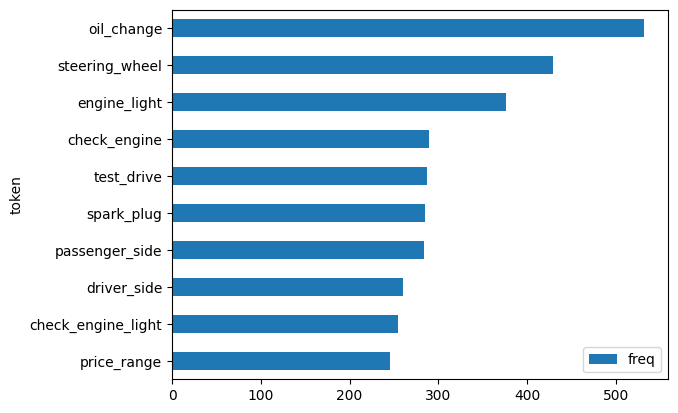

In [100]:
count_words(df, 'noun_phrases').head(10).plot(kind='barh').invert_yaxis()